# Exercise - Neural Network

The data set for this exercise is from the banking industry. It contains data about the home loans of 2,500 bank clients. Each row represents a single loan. The columns include the characteristics of the client who used a loan. This is a binary classification task: predict whether a loan will be bad or not (1=Yes, 0=No). This is an important task for banks to prevent bad loans from being issued.

## Description of Variables

The description of variables are provided in "Loan - Data Dictionary.docx"

## Goal

Use the **loan.csv** data set and build a model to predict **BAD**. 



# Read and Prepare the Data

In [15]:
# Common imports

import pandas as pd
import numpy as np

np.random.seed(42)

# Get the data

In [17]:
#We will predict the "price" value in the data set:

loan = pd.read_csv("loan.csv")
loan.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,0,25900,61064.0,94714.0,DebtCon,Office,2.0,0.0,0.0,98.809375,0.0,23.0,34.565944
1,0,26100,113266.0,182082.0,DebtCon,Sales,18.0,0.0,0.0,304.852469,1.0,31.0,33.193949
2,1,50000,220528.0,300900.0,HomeImp,Self,5.0,0.0,0.0,0.000000,0.0,2.0,NaN
3,1,22400,51470.0,68139.0,DebtCon,Mgr,9.0,0.0,0.0,31.168696,2.0,8.0,37.952180
4,0,20900,62615.0,87904.0,DebtCon,Office,5.0,NaN,NaN,177.864849,NaN,15.0,36.831076


# Split data (train/test)

In [19]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(loan, test_size=0.3)

# Data Prep

Perform your data prep here. You can use pipelines like we do in the tutorials. Otherwise, feel free to use your own data prep steps. Eventually, you should do the following at a minimum:<br>
- Separate inputs from target<br>
- Impute/remove missing values<br>
- Standardize the continuous variables<br>
- One-hot encode categorical variables<br>

In [21]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer

## Separate the target variable 

In [23]:
train_target = train['BAD']
test_target = test['BAD']

train_inputs = train.drop(['BAD'], axis=1)
test_inputs = test.drop(['BAD'], axis=1)

## Feature Engineering: Derive a new column

Examples:
- Ratio of delinquent to total number of credit lines
- Ratio of loan to value of current property
- Convert yr_renovated to a binary variable (i.e., renovated or not)
- (etc.)

In [25]:
print(train_inputs.columns)


Index(['LOAN', 'MORTDUE', 'VALUE', 'REASON', 'JOB', 'YOJ', 'DEROG', 'DELINQ',
       'CLAGE', 'NINQ', 'CLNO', 'DEBTINC'],
      dtype='object')


In [26]:
# Let's analyze "loans"

train_inputs['LOAN'].describe()

count     1750.000000
mean     18142.457143
std      11280.619735
min       1100.000000
25%      10600.000000
50%      15700.000000
75%      23075.000000
max      89000.000000
Name: LOAN, dtype: float64

In [27]:
train_inputs['LOAN'].value_counts()

LOAN
15000    43
10000    36
20000    27
25000    26
12000    23
         ..
40600     1
45100     1
33300     1
52900     1
2800      1
Name: count, Length: 402, dtype: int64

<Axes: >

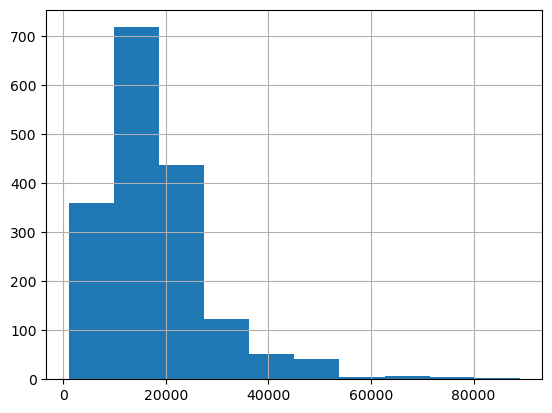

In [28]:
train_inputs['LOAN'].hist()

Ratio of loan to value of current property

In [30]:
def new_col(df):
    
    #Create a copy so that we don't overwrite the existing dataframe
    df1 = df.copy()

    # Use the formula, though fill in 0s when the value is 0/0 (because 0/0 generates "nan" values)
    df1['delinquet_vs_total credit line'] = (df1['DELINQ']/df1['CLNO']).fillna(0)

    # Replace the infinity values with 1 (because a value divided by 0 generates infinity)
    df1['delinquet_vs_total credit line'].replace(np.inf, 1, inplace=True)

    return df1[['delinquet_vs_total credit line']]
    # You can use this to check whether the calculation is made correctly:
    #return df1

In [31]:
#Let's test the new function:

# Send the train set to the function we created
new_col(train_inputs)

/var/folders/x3/xjqdf_1561zch36b9hs3lr_80000gn/T/ipykernel_848/1888928261.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df1['delinquet_vs_total credit line'].replace(np.inf, 1, inplace=True)


,delinquet_vs_total credit line
1552,0.000000
2290,0.000000
1398,0.000000
1775,0.035714
2299,0.000000
...,...
1638,0.125000
1095,0.181818
1130,0.000000
1294,0.000000


In [32]:
train_target

1552    0
2290    1
1398    1
1775    0
2299    0
       ..
1638    1
1095    1
1130    0
1294    0
860     1
Name: BAD, Length: 1750, dtype: int64

##  Identify the numeric, binary, and categorical columns

In [34]:
# Identify the numerical columns
numeric_columns = train_inputs.select_dtypes(include=[np.number]).columns.to_list()

# Identify the categorical columns
categorical_columns = train_inputs.select_dtypes('object').columns.to_list()

In [35]:
numeric_columns

['LOAN',
 'MORTDUE',
 'VALUE',
 'YOJ',
 'DEROG',
 'DELINQ',
 'CLAGE',
 'NINQ',
 'CLNO',
 'DEBTINC']

In [36]:
categorical_columns

['REASON', 'JOB']

In [37]:
# define your feature engineered column(s) here
feat_eng_columns = ['DELINQ','CLNO'] 

# Pipeline

In [39]:
numeric_transformer = Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())])

In [40]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [41]:
# Create a pipeline for the transformed column here
my_new_column = Pipeline(steps=[('my_new_column', FunctionTransformer(new_col)),
                               ('scaler', StandardScaler())])



In [42]:
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_columns),
    ('cat', categorical_transformer, categorical_columns),
    ('trans', my_new_column, feat_eng_columns)], remainder='passthrough')
#passtrough is an optional step. You don't have to use it.

# Transform: fit_transform() for TRAIN

In [44]:
#Fit and transform the train data
train_x = preprocessor.fit_transform(train_inputs)

train_x

/var/folders/x3/xjqdf_1561zch36b9hs3lr_80000gn/T/ipykernel_848/1888928261.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df1['delinquet_vs_total credit line'].replace(np.inf, 1, inplace=True)


array([[-0.31412013, -1.30301181, -0.86148829, ...,  0.        ,
         0.        , -0.42345858],
       [ 0.45733454,  0.7398414 ,  0.58636192, ...,  0.        ,
         0.        , -0.42345858],
       [-1.10330939,  0.2001631 ,  0.18146318, ...,  0.        ,
         0.        , -0.42345858],
       ...,
       [-0.21657988, -0.83000156, -0.82081329, ...,  0.        ,
         0.        , -0.42345858],
       [-0.46486414,  1.79196675,  1.36974799, ...,  0.        ,
         0.        , -0.42345858],
       [-0.31412013, -0.08740643, -0.21782887, ...,  0.        ,
         0.        , -0.42345858]])

In [45]:
train_x.shape

(1750, 21)

# Tranform: transform() for TEST

In [47]:
# Transform the test data
test_x = preprocessor.transform(test_inputs)

test_x

/var/folders/x3/xjqdf_1561zch36b9hs3lr_80000gn/T/ipykernel_848/1888928261.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df1['delinquet_vs_total credit line'].replace(np.inf, 1, inplace=True)


array([[ 0.06717356,  0.36706438,  0.32127798, ...,  0.        ,
         0.        , -0.42345858],
       [ 0.32432512,  0.57631513,  0.42769944, ...,  1.        ,
         0.        , -0.42345858],
       [-0.33185472,  0.41209537,  0.12227549, ...,  0.        ,
         0.        , -0.42345858],
       ...,
       [-0.8993616 , -0.51071616, -0.32326299, ...,  0.        ,
         0.        ,  2.31481716],
       [-0.5446698 , -0.82706576, -0.8366813 , ...,  0.        ,
         0.        , -0.42345858],
       [-0.5446698 , -0.06422056, -0.11380525, ...,  0.        ,
         0.        , -0.42345858]])

In [48]:
test_x.shape

(750, 21)

# Calculate the Baseline

In [50]:
# Find percentage
train_target.value_counts()/len(train_target)

BAD
0    0.603429
1    0.396571
Name: count, dtype: float64

In [51]:
# Sci-kit Learn's DummyClassifier automates the entire process performed manually above.
# First, you instantiate it with the "most_frequent" strategy. 
# Then, you fit the model. This finds the most frequently (i.e., majority) class (in the training set).

from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")

dummy_clf.fit(train_x, train_target)

DummyClassifier(strategy='most_frequent')

In [52]:
from sklearn.metrics import accuracy_score

In [53]:
# Then, you call the predict function of the classifier.
# This predicts all values as the majority class.
# In the next step, you compare the predicted values with the actual values to calculate accuracy
# This is the baseline Train Accuracy

dummy_train_pred = dummy_clf.predict(train_x)

baseline_train_acc = accuracy_score(train_target, dummy_train_pred)

print('Baseline Train Accuracy: {}' .format(baseline_train_acc))

Baseline Train Accuracy: 0.6034285714285714


In [54]:
# We repeat the same steps for the test set
# This is the baseline Test Accuracy

dummy_test_pred = dummy_clf.predict(test_x)

baseline_test_acc = accuracy_score(test_target, dummy_test_pred)

print('Baseline Test Accuracy: {}' .format(baseline_test_acc))

Baseline Test Accuracy: 0.5773333333333334


# Train a shallow (one-layer) NN model

In [56]:
from sklearn.neural_network import MLPClassifier

#Default settings create 1 hidden layer with 100 neurons
mlp_clf = MLPClassifier(hidden_layer_sizes=(1,))

mlp_clf.fit(train_x, train_target)

MLPClassifier(hidden_layer_sizes=(1,))

### Calculate the accuracy

In [60]:
from sklearn.metrics import accuracy_score



In [62]:
#Predict the train values
train_y_pred = mlp_clf.predict(train_x)

#Train accuracy
accuracy_score(train_target, train_y_pred)

0.744

In [66]:
#Predict the test values
test_y_pred = mlp_clf.predict(test_x)

#Test accuracy
accuracy_score(test_target, test_y_pred)

0.716

# Train a deep (multi-layered) NN model 

In [73]:
from sklearn.neural_network import MLPClassifier

#Default settings create 1 hidden layer with 100 neurons
mlp_clf = MLPClassifier(hidden_layer_sizes=(100,))

mlp_clf.fit(train_x, train_target)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier()

### Calculate the accuracy

In [96]:
from sklearn.metrics import accuracy_score

In [98]:
#Predict the train values
train_y_pred = mlp_clf.predict(train_x)

#Train accuracy
accuracy_score(train_target, train_y_pred)

0.9022857142857142

In [100]:
#Predict the test values
test_y_pred = mlp_clf.predict(test_x)

#Test accuracy
accuracy_score(test_target, test_y_pred)

0.836

In [102]:
dnn_clf = MLPClassifier(hidden_layer_sizes=(50,25,10),
                       max_iter=1000)

dnn_clf.fit(train_x, train_target)

MLPClassifier(hidden_layer_sizes=(50, 25, 10), max_iter=1000)

In [103]:
#Let's check the number of iterations:
dnn_clf.n_iter_

463

In [104]:
#Let's check the number of layers:
dnn_clf.n_layers_

5

In [105]:
#Predict the train values
train_y_pred = dnn_clf.predict(train_x)

#Train accuracy
accuracy_score(train_target, train_y_pred)

1.0

In [106]:
#Predict the test values
test_y_pred = dnn_clf.predict(test_x)

#Test accuracy
accuracy_score(test_target, test_y_pred)

0.8426666666666667

# Optional: try grid search

In [112]:
#Select a random observation

random = test_x[50:51]
random

array([[ 0.58147667,  0.90914681,  1.13846292,  0.96404469, -0.32183497,
         0.30975577,  0.03084123, -0.15169086,  0.48602604, -0.17746767,
         1.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.10313291]])

In [114]:
# Observe the input variables of the observation
dnn_clf.predict_proba(random)

array([[0.65745568, 0.34254432]])

In [116]:
# Round the probability values
np.round(dnn_clf.predict_proba(random), 2)

array([[0.66, 0.34]])